### Data preprocessing

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import json
import string
import re
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SOS_token = 0
EOS_token = 1

In [3]:
def vocab2idx(vocab):
    output_idx = [SOS_token]
    for i in vocab:
        output_idx.append(ord(i) % 97 + 2)
    output_idx.append(EOS_token)
    # return output_ascii
    return torch.tensor(output_idx, dtype=torch.long, device=device).view(-1, 1)

def idx2vocab(idx):
    vocab = ""
    for i in idx:
        if i > 1:
            vocab += chr(i + 95)
    return vocab

In [4]:
class MyDataset(Dataset):
    # data loading
    
    def __init__(self, filepath):
        
        self.dataset = []
        with open(filepath) as f:
            data = json.load(f)
            
        for i in range(len(data)):
            for j in range(len(data[i]['input'])):
                self.dataset.append((vocab2idx(data[i]['input'][j]), vocab2idx(data[i]['target'])))
    #     random.shuffle(self.dataset)
    # working for indexing
    def __getitem__(self, index):
        
        return self.dataset[index]

    # return the length of our dataset
    def __len__(self):
        
        return len(self.dataset)
    def item(self):
        
        return self.dataset

In [5]:
trainDataset = MyDataset('train.json')
trainDataset[0]
# print(len(cls_num))
# cls_num
# trainloader = DataLoader(trainDataset, batch_size=1, num_workers=4, shuffle=True)
# dataiter = iter(trainloader)
# data = dataiter.next()
# data

(tensor([[ 0],
         [ 2],
         [14],
         [ 6],
         [19],
         [ 2],
         [ 4],
         [ 2],
         [ 1]], device='cuda:0'),
 tensor([[ 0],
         [ 2],
         [14],
         [ 6],
         [19],
         [10],
         [ 4],
         [ 2],
         [ 1]], device='cuda:0'))

In [6]:
#----------Hyper Parameters----------#
hidden_size = 256
#The number of vocabulary
vocab_size = 28
teacher_forcing_ratio = 0.4
LR = 0.05
Bleu_score_history = []
Accuracy_history = []
#compute BLEU-4 score
def compute_bleu_accuracy(output, target):
    cc = SmoothingFunction()
    output_len = len(output)
    target_len = len(target)
    
    weights = tuple((1/target_len) for i in range(target_len))
    Bleu_score_history.append(sentence_bleu([target], output,weights=weights,smoothing_function=cc.method1))
    
    if output == target:
        Accuracy_history.append(1.0)
    else:
        correct_num = 0.0
        max_len = np.maximum(output_len,target_len)
        min_len = np.minimum(output_len,target_len)

        for i in range(min_len):
            if output[i] == target[i]:
                correct_num += 1
        Accuracy_history.append(correct_num/max_len) 

      

In [7]:
num_layers = 2
bidirectional = 2
#Encoder 
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size,)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, num_layers, bidirectional=True, dropout=0.2)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.LSTM(output, hidden)
        return output, hidden

    def initHidden(self):
        h = torch.zeros(num_layers * bidirectional, 1, self.hidden_size, device=device)
        c = torch.zeros(num_layers * bidirectional, 1, self.hidden_size, device=device)
        return (h,c)

#Decoder
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, num_layers, bidirectional=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.LSTM(output, hidden)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self):
        h = torch.zeros(num_layers * bidirectional, 1, self.hidden_size, device=device)
        c = torch.zeros(num_layers * bidirectional, 1, self.hidden_size, device=device)
        return (h,c)

class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.3):
        super(AttnDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.attn_emb_fc = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_h_fc = [nn.Linear(self.hidden_size, self.hidden_size).to(device) for i in range(4)]
        self.attn_c_fc = [nn.Linear(self.hidden_size, self.hidden_size).to(device) for i in range(4)]
        
        self.LSTM = nn.LSTM(self.hidden_size, self.hidden_size, num_layers, bidirectional=True, dropout=dropout_p)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)
        
    def attn_net(self, encoder_output, hidden):
        out = self.attn_emb_fc(encoder_output)
        out = F.relu(out)
        out = out.mean(0,keepdim=True) 
        
        h_attn_weight = torch.zeros(num_layers * 2, 1, hidden_size, device=device)
        c_attn_weight = torch.zeros(num_layers * 2, 1, hidden_size, device=device)

        for i in range(4):
            h_attn_weight[i] = F.relu(self.attn_h_fc[i](out))
            c_attn_weight[i] = F.relu(self.attn_c_fc[i](out))
        h_attn =  torch.mul(hidden[0], h_attn_weight)   
        c_attn =  torch.mul(hidden[1], c_attn_weight)

        return (h_attn, c_attn)
    
    def forward(self, input, hidden, encoder_output):
        embedded = self.embedding(input).view(1,1,-1)
        attn_output = self.attn_net(encoder_output, hidden)

        output, hidden = self.LSTM(embedded, attn_output)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden

    def initHidden(self):
        h = torch.zeros(num_layers * bidirectional, 1, self.hidden_size, device=device)
        c = torch.zeros(num_layers * bidirectional, 1, self.hidden_size, device=device)
        return (h,c)

In [8]:
BS_PerEpoch_history = [] #record avg bleu score of each epoch
Acc_PerEpoch_history = [] #record avg accuracy of each epoch
Loss_PerEpoch_history = [] #record avg accuracy of each epoch

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    

    loss = 0
    #----------sequence to sequence part for encoder----------#
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
	
    decoded_words = []

    #----------sequence to sequence part for decoder----------#
    if use_teacher_forcing:
        for di in range(target_length):
        # Teacher forcing: Feed the target as the next input
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_output)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            topv, topi = decoder_output.topk(1)
            decoded_words.append(topi.item())
    else:
        for di in range(target_length):
        # Without teacher forcing: use its own predictions as the next input
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoded_words.append(topi.item())
            
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
            
    compute_bleu_accuracy(idx2vocab(decoded_words), idx2vocab(target_tensor))
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



def trainIters(encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    print_loss_total = 0  # Reset every print_every
    epoch_total_lose = 0
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # your own dataloader

    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        random.shuffle(trainDataset.item())
        for i, data in enumerate(trainDataset, 0):
            input_tensor = data[0]
            target_tensor = data[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            epoch_total_lose += loss

            curr_iter = i + (epoch-1) * len(trainDataset)
            iter_num = epochs * len(trainDataset)
            if curr_iter % print_every == 1:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                percent = curr_iter / iter_num
                print('\n%s (iter_%d %.2f%%) Avg loss: %.4f' % (timeSince(start, percent),
                                        curr_iter, percent * 100.0, print_loss_avg))
                print(f"Avg Bleu score: {np.mean(Bleu_score_history)}, Avg Accuracy: {np.mean(Accuracy_history)}")
        
        Loss_PerEpoch_history.append(epoch_total_lose/len(trainDataset))
        epoch_total_lose = 0
        
        BS_PerEpoch_history.append(np.mean(Bleu_score_history))
        Bleu_score_history.clear()
        
        Acc_PerEpoch_history.append(np.mean(Accuracy_history))
        Accuracy_history.clear()
        
encoder1 = EncoderLSTM(vocab_size, hidden_size).to(device)
attn_decoder1 = AttnDecoderLSTM(hidden_size, vocab_size, dropout_p=0.3).to(device)
trainIters(encoder1, attn_decoder1, 100, print_every=10000)



0m 0s (- 5281m 52s) (iter_1 0.00%) Avg loss: 0.0007
Avg Bleu score: 0.014067650920292545, Avg Accuracy: 0.0625

3m 56s (- 505m 58s) (iter_10001 0.77%) Avg loss: 2.1373
Avg Bleu score: 0.046222985087015715, Avg Accuracy: 0.13308864284419172

8m 3s (- 512m 53s) (iter_20001 1.55%) Avg loss: 1.4639
Avg Bleu score: 0.12673895938473947, Avg Accuracy: 0.44182664488813655

12m 12s (- 513m 43s) (iter_30001 2.32%) Avg loss: 1.2812
Avg Bleu score: 0.16152024692687925, Avg Accuracy: 0.5117554754715796

16m 24s (- 513m 36s) (iter_40001 3.09%) Avg loss: 1.1643
Avg Bleu score: 0.20355733739561233, Avg Accuracy: 0.5634943884332636

20m 37s (- 512m 28s) (iter_50001 3.87%) Avg loss: 1.1349
Avg Bleu score: 0.19244874563102246, Avg Accuracy: 0.5540565803732591

24m 48s (- 509m 45s) (iter_60001 4.64%) Avg loss: 1.0778
Avg Bleu score: 0.21539235333477558, Avg Accuracy: 0.5797341112807266

28m 59s (- 506m 19s) (iter_70001 5.42%) Avg loss: 1.0645
Avg Bleu score: 0.21543405279324226, Avg Accuracy: 0.577114394

In [9]:
encoder_dict_FILE = 'encoder_state_dict.pt'
attn_decoder_dict_FILE = 'attn_decoder_state_dict.pt'

torch.save(encoder1.state_dict(), encoder_dict_FILE)
torch.save(attn_decoder1.state_dict(), attn_decoder_dict_FILE)

<function matplotlib.pyplot.show(close=None, block=None)>

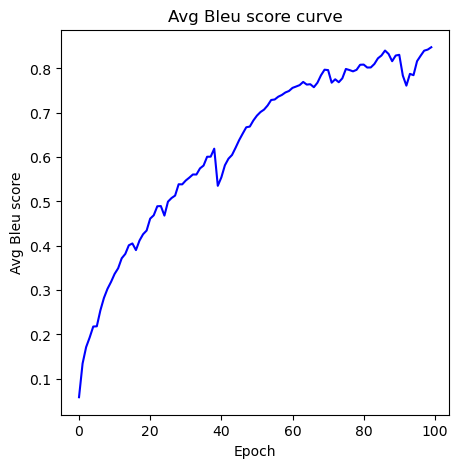

In [10]:
%matplotlib inline
plt.figure(figsize=(5, 5))
plt.title("Avg Bleu score curve")
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Avg Bleu score', fontsize=10)
plt.plot(BS_PerEpoch_history, 'b')
plt.savefig('bs.png') 
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

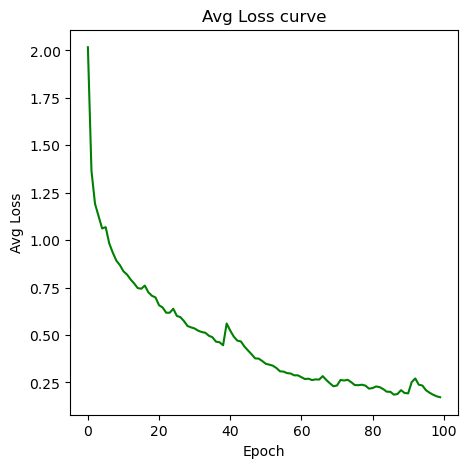

In [11]:
plt.figure(figsize=(5, 5))
plt.title("Avg Loss curve")
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Avg Loss', fontsize=10)
plt.plot(Loss_PerEpoch_history, 'g')
plt.savefig('loss.png') 
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

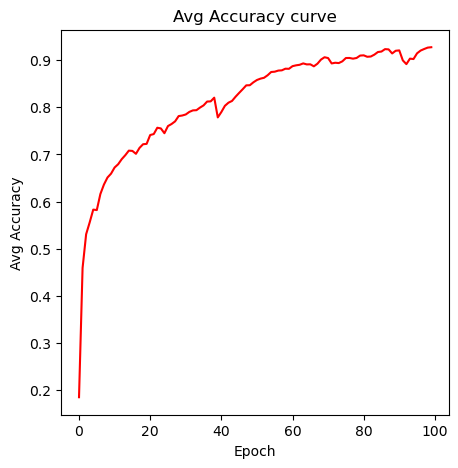

In [12]:
plt.figure(figsize=(5, 5))
plt.title("Avg Accuracy curve")
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Avg Accuracy', fontsize=10)
plt.plot(Acc_PerEpoch_history, 'r')
plt.savefig('acc.png') 
plt.show

In [13]:
test_files = ['test.json', 'new_test.json']
testDataset = MyDataset(test_files[0])
n_testDataset = MyDataset(test_files[1])

In [14]:
def evaluate(encoder, decoder, data):
    with torch.no_grad():
        
        input = data[0]
        target = data[1]
        
        encoder_hidden = encoder.initHidden()
        encoder_output, encoder_hidden = encoder(input, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []

        for i in range(len(input)):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoded_words.append(topi.item())
            decoder_input = topi.squeeze().detach()
        decoded_words = idx2vocab(decoded_words)
        compute_bleu_accuracy(decoded_words, idx2vocab(target))
        
        return decoded_words

In [15]:
testset = [testDataset, n_testDataset]
for dataset in testset:
    
    print(f"\n {test_files[testset.index(dataset)]}:")
    Bleu_score_history.clear()     
    Accuracy_history.clear()
    
    for data in dataset:
        
        pred = evaluate(encoder1, attn_decoder1, data)
        print("="*20)
        print(f"input:  {idx2vocab(data[0])}")
        print(f"target: {idx2vocab(data[1])}")
        print(f"pred:   {pred}")
    print(f"Bleu-4 score: {np.mean(Bleu_score_history)}, Accuracy: {np.mean(Accuracy_history)}")


 test.json:
input:  contenpted
target: contented
pred:   contempted
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   potery
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  stanerdizing
target: standardizi